<a href="https://colab.research.google.com/github/mz256/CIFAR10/blob/main/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 with PyTorch

Test the performance of various models on the CIFAR10 dataset. Models are logistic regression, single-layer MLP and two different CNN architectures.

## `Dataset`s and `DataLoader`s



In [1]:
#!pip list
import torch
import torchvision

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

Define transformations to apply to raw data. Apart from converting PIL to tensors, we also normalise each colour channel (which leads to better performance, see [here](https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/) for more information).

In [4]:
tfms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])

In [5]:
dataset = CIFAR10(root='/content/data',
                  download=True,
                  transform=tfms)
len(dataset)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/data/cifar-10-python.tar.gz to /content/data


50000

In [6]:
test_dataset = CIFAR10(root='/content/data',
                       download=True,
                       train=False,
                       transform=tfms) # always normalise test set same way as training set
len(test_dataset)

Files already downloaded and verified


10000

The RGB image data has range 0-255. These values are stored (unmodified, irrespective of the transforms invoked) in a numpy ndarray in the attribute `Dataset.data`. On the other hand, the effects of the transforms applied are reflected in each object present in the Dataset, such as `dataset[0][0]`. In this case, this is a tensor with range [-1, 1]. This is because `ToTensor` converts PIL to scaled tensors with range [0, 1], so that the call to Normalize maps to [-1, 1], e.g. the min (0) maps to (0-0.5)/0.5=-1.

We can manually check what the Normalize transform does:

In [7]:
t1 = dataset[0][0]
t2 = (torch.from_numpy(dataset.data[0]).permute(2,0,1)/255 - 0.5) / 0.5
torch.equal(t1, t2)

True

We could also wish to train the model with z-scores, i.e. normalising with actual mean and std of training data, instead of with data scaled to range [-1, 1].

In [8]:
means = dataset.data.mean(axis=(0,1,2))/255
stds = dataset.data.std(axis=(0,1,2))/255  # note: std(cX) = |c|std(X)
means, stds

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

In [9]:
img_tensor, label = dataset[0]
img_tensor, label, img_tensor.shape

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
          [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
          [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
          ...,
          [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
          [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
          [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
 
         [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
          [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
          [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
          ...,
          [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
          [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
          [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],
 
         [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
          [-0.8431, -1.0000,

We transform images to tensors at download because we will work with tensors all along. If we wanted to print the images, we can easily convert them to PIL.

<class 'PIL.Image.Image'>


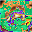

In [10]:
image = transforms.ToPILImage()(img_tensor)
print(type(image))
image

Notice that:
- Simply asking to print the object returns the `PIL.Image` in actual size (32x32 is very small), so we use `plt.imshow`
- We normalised the colour channels earlier, which creates colour distortion (left); however, a simple un-standardisation lets us print the original image (right).

Label: 6


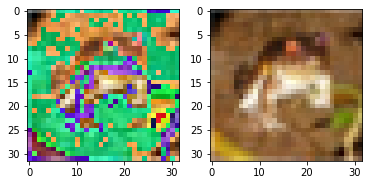

In [11]:
_, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(image)
image_orig = (img_tensor * 0.5) + 0.5
image_orig = transforms.ToPILImage()(image_orig)
ax2.imshow(image_orig)
print(f'Label: {label}')

`Dataset` provides one sample at a time. We split this into training and validation sets. `DataLoader` provides an iterable for samples grouped in minibatches.

In [12]:
from torch.utils.data import random_split, DataLoader

train_ds , valid_ds = random_split(dataset, [40000, 10000])
len(train_ds), len(valid_ds)

(40000, 10000)

In [13]:
bs = 128
train_loader = DataLoader(train_ds, bs, shuffle=True)
valid_loader = DataLoader(valid_ds, bs)

In [14]:
for xb, yb in train_loader:
  print(f'The shape of an image batch is: {xb.shape}\n')
  print(yb)
  break

The shape of an image batch is: torch.Size([128, 3, 32, 32])

tensor([2, 6, 7, 0, 1, 9, 4, 4, 7, 3, 2, 2, 4, 4, 1, 4, 4, 6, 6, 6, 2, 9, 0, 1,
        6, 3, 7, 5, 2, 3, 8, 5, 1, 0, 8, 9, 3, 1, 7, 4, 7, 7, 5, 3, 6, 8, 4, 9,
        4, 5, 6, 9, 3, 6, 4, 3, 4, 9, 7, 9, 6, 8, 5, 1, 0, 5, 9, 7, 6, 1, 5, 8,
        3, 5, 4, 9, 1, 9, 5, 9, 6, 0, 0, 9, 6, 2, 2, 0, 3, 7, 4, 4, 8, 6, 1, 2,
        8, 1, 4, 7, 1, 0, 4, 5, 5, 3, 1, 2, 1, 0, 6, 4, 2, 9, 2, 1, 3, 2, 0, 5,
        2, 7, 2, 8, 6, 0, 1, 7])


We can visualise one batch with the built-in `make_grid` function.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


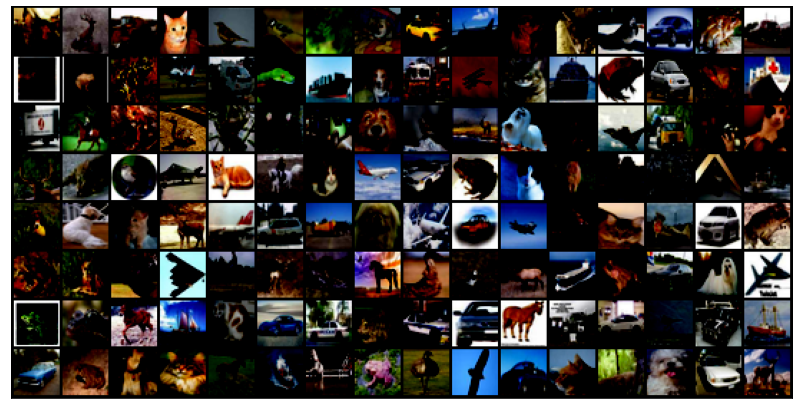

In [15]:
from torchvision.utils import make_grid

def show_batch(dl):
  for xb, yb in dl:
    fig, ax = plt.subplots(figsize=(14,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(xb, nrow=16).permute(1,2,0))
    break

show_batch(train_loader)

## 1. Logistic regression model

In [16]:
import torch.nn as nn

Let us write models from scratch to practice PyTorch syntax. First, let's create a single-layer NN (with 10 output nodes), which is equivalent to a multi-class logistic regression. Note that the model `forward` method will return raw outputs, since we will use the loss function `F.cross_entropy`, which implements a softmax activation layer.

In [17]:
class LogisticModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(3*32*32, 10)

  def forward(self, xb):
    # Reshape the input, so that each element of the batch is vectorised
    xb = xb.reshape(-1, 3*32*32)
    out = self.linear(xb)
    return out

In [18]:
model1 = LogisticModel()
outputs = model1(xb)
#print(outputs)
print(outputs.shape)

torch.Size([128, 10])


We need to define:

- *a loss function*: use multinomial cross-entropy,
- *a performance metric*: use average accuracy.

In [19]:
import torch.nn.functional as F

loss_fn = F.cross_entropy

# Test it on one batch:
loss = loss_fn(outputs, yb)
loss

tensor(2.3522, grad_fn=<NllLossBackward>)

In [20]:
def accuracy(outputs, labels):
  probs = F.softmax(outputs, dim=1)
  maxvals, preds = torch.max(probs, dim=1)
  return torch.sum(preds == labels) / len(preds)

accuracy(outputs, yb)

tensor(0.1094)

The training loop could be explicit, like so:

In [21]:
def train_epoch_old(model, lr=0.001):
  for xb, yb in train_loader:

    # compute gradients
    outputs = model(xb)
    loss = loss_fn(outputs, yb)
    loss.backward()

    # update model's parameters
    for param in model.parameters():
      param.data = param.data - lr*param.grad
      param.grad.zero_()

Or refactored in two parts: (a) a function computing the gradient with backpropagation and (b) an optimisation algorithm, such as SGD, implemented as a class to mimic PyTorch behaviour.

In [22]:
def compute_grad(xb, yb, model, loss_fn):
  outputs = model(xb)
  loss = loss_fn(outputs, yb)
  loss.backward()


class SGD_Optim:
  """SGD optimiser from scratch"""
  def __init__(self, params, lr):
    self.params = list(params)  # generator expression (params) does not work, so use list
    self.lr = lr
  
  def step(self, *args, **kwargs):
    for p in self.params:
      p.data -= self.lr * p.grad.data
    
  def zero_grad(self, *args, **kwargs):
    for p in self.params:
      p.grad.zero_()

Now we can refactor the training loop. We also need a function to quickly evaluate performance on the validation set. Let us also put them together in a single routine for training and evaluation of multiple epochs.

In [23]:
def train_epoch(model, loss_fn, opt):
  for xb, yb in train_loader:
    compute_grad(xb, yb, model, loss_fn)
    opt.step()
    opt.zero_grad()


def validate_epoch(model, lengths_train, lengths_valid):
  # accuracy, training and validation loss on each batch
  accuracies = [accuracy(model(xb), yb) for xb, yb in valid_loader]
  train_losses = torch.tensor([loss_fn(model(xb), yb) for xb, yb in train_loader])
  valid_losses = torch.tensor([loss_fn(model(xb), yb) for xb, yb in valid_loader])

  # total accuracy, training and validation loss per epoch
  total_accuracy = round(torch.stack(accuracies).mean().item(), 4)
  train_loss = round(torch.sum(train_losses*lengths_train).item() / torch.sum(lengths_train).item(), 4)
  valid_loss = round(torch.sum(valid_losses*lengths_valid).item() / torch.sum(lengths_valid).item(), 4)
  return (total_accuracy, train_loss, valid_loss)


def train_model(epochs, model, opt):
  """Routine for model training and evaluation"""
  acc_list = []
  for _ in range(epochs):
    train_epoch(model, loss_func, opt)
    acc, train_loss, valid_loss = validate_epoch(model, l_train, l_valid)
    print(f'Accuracy: {acc}, train_loss: {train_loss} and valid_loss: {valid_loss}')
    acc_list.append(acc)
  return acc_list

Instantiate all necessary objects and check performance before training.

In [24]:
# sizes of batches, computed once for validate_epoch
l_train = torch.tensor([len(yb) for xb, yb in train_loader])
l_valid = torch.tensor([len(yb) for xb, yb in valid_loader])

# check validation set performance before training, as baseline
model1 = LogisticModel()
opt = SGD_Optim(model1.parameters(), lr=0.01)
loss_func = F.cross_entropy
validate_epoch(model1, l_train, l_valid)

(0.1104, 2.3342, 2.3329)

Train the model.

In [25]:
acc_valid = train_model(10, model1, opt)

Accuracy: 0.371, train_loss: 1.815 and valid_loss: 1.8235
Accuracy: 0.3924, train_loss: 1.7719 and valid_loss: 1.7848
Accuracy: 0.3952, train_loss: 1.7429 and valid_loss: 1.7636
Accuracy: 0.3958, train_loss: 1.7273 and valid_loss: 1.7512
Accuracy: 0.4046, train_loss: 1.7125 and valid_loss: 1.7379
Accuracy: 0.4041, train_loss: 1.7038 and valid_loss: 1.7332
Accuracy: 0.4041, train_loss: 1.6991 and valid_loss: 1.7317
Accuracy: 0.4062, train_loss: 1.6898 and valid_loss: 1.7279
Accuracy: 0.404, train_loss: 1.6811 and valid_loss: 1.725
Accuracy: 0.4097, train_loss: 1.6772 and valid_loss: 1.7213


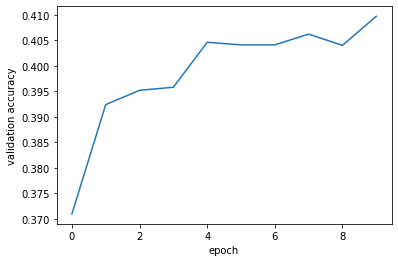

In [26]:
plt.plot(acc_valid)
plt.xlabel('epoch')
plt.ylabel('validation accuracy');

Save model parameters.

In [27]:
torch.save(model1.state_dict(), 'mnist-logistic.pth')

# to be loaded back for new model instance, e.g.
# model1_new = LogisticModel()
# model1_new.load_state_dict(torch.load('mnist-logistic.pth'))

Notes to self:
- Training with data in range [-1, 1] (i.e. normalising with mean=0.5 and std=0.5) leads to the best results versus (a) un-normalised data or (b) z-scores.

### Example of inference

In [28]:
test_loader = DataLoader(test_dataset, bs, shuffle=False)

In [29]:
def test_performance(model):
  # accuracy on each batch
  accuracies = [accuracy(model(xb), yb) for xb, yb in test_loader]
  # total accuracy
  total_accuracy = round(torch.stack(accuracies).mean().item(), 4)
  return (total_accuracy)

Let us check the performance on the test set.

In [30]:
test_performance(model1)

0.4055

Furthermore, we can inspect the model's performance by category, to start gaining insights of what might be improved.

In [31]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():
  for xb, yb in test_loader:
    outputs = model1(xb)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == yb)
    for i in range(len(yb)):
      y = yb[i]
      class_correct[y] += c[i]
      class_total[y] += 1

for i in range(10):
  print(f"Accuracy of class {classes[i]}: {100*class_correct[i]/class_total[i]:.0f}%")

Accuracy of class plane: 44%
Accuracy of class car: 49%
Accuracy of class bird: 28%
Accuracy of class cat: 26%
Accuracy of class deer: 25%
Accuracy of class dog: 34%
Accuracy of class frog: 50%
Accuracy of class horse: 48%
Accuracy of class ship: 57%
Accuracy of class truck: 47%


## 2. Multi-layer Perceptron

Let us extend the model to include a single hidden layer. We can still use the same batch size.

In [32]:
bs = 128
train_loader = DataLoader(train_ds, bs, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_ds, bs*2, num_workers=2, pin_memory=True)

In [33]:
class MLP_model(nn.Module):
  """Feedforward neural network with single hidden layer"""

  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, out_size)
  
  def forward(self, xb):
    xb = xb.reshape(xb.size(0), -1)
    hidden = self.linear1(xb)
    hidden = F.relu(hidden)
    out = self.linear2(hidden)
    return out

Instantiate the model with a 32-node hidden layer and 10 output nodes.

In [34]:
model2 = MLP_model(3072, 32, 10)

Check a forward pass for this model.

In [35]:
for xb, yb in train_loader:
  outputs = model2(xb)
  loss = F.cross_entropy(outputs, yb)
  print(f'Loss: {loss.item()}')
  break

print(outputs.shape)

Loss: 2.3269731998443604
torch.Size([128, 10])


We will need to move both data and model to GPU. Let us write some helper functions.

In [36]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')


def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  else:
    return data.to(device)


class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    """Yield a batch of data after moving it"""
    for batch in self.dl:
      yield to_device(batch, device)
  

Check that we correctly pick GPU when available.

In [37]:
device = get_default_device()
device

device(type='cuda')

Check that we can correctly move a batch to GPU.

In [38]:
for xb, yb in train_loader:
  print(xb.shape, xb.device)
  xb = to_device(xb, device)
  print(xb.shape, xb.device)
  break

torch.Size([128, 3, 32, 32]) cpu
torch.Size([128, 3, 32, 32]) cuda:0


Move entire dataloaders, including the test.

In [39]:
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

Specifiy model (and move it to GPU), optimiser and loss function. Obtain baseline performance before training.

In [40]:
# sizes of batches, computed once for validate_epoch
l_train = torch.tensor([len(yb) for xb, yb in train_loader])
l_valid = torch.tensor([len(yb) for xb, yb in valid_loader])

# check validation set performance before training, as baseline
model2 = MLP_model(3072, 32, 10)
to_device(model2, device)
opt2 = SGD_Optim(model2.parameters(), lr=0.5)
loss_func = F.cross_entropy
validate_epoch(model2, l_train, l_valid)

(0.0979, 2.3097, 2.3093)

Train model with custom-built SGD optimiser.

In [41]:
acc_valid_2 = train_model(10, model2, opt2)

Accuracy: 0.3245, train_loss: 1.9304 and valid_loss: 1.954
Accuracy: 0.3822, train_loss: 1.7001 and valid_loss: 1.7539
Accuracy: 0.3913, train_loss: 1.6756 and valid_loss: 1.7503
Accuracy: 0.3686, train_loss: 1.8146 and valid_loss: 1.9254
Accuracy: 0.3896, train_loss: 1.6713 and valid_loss: 1.8052
Accuracy: 0.3584, train_loss: 1.9472 and valid_loss: 2.0961
Accuracy: 0.3622, train_loss: 1.7605 and valid_loss: 1.9578
Accuracy: 0.3641, train_loss: 1.7335 and valid_loss: 1.9268
Accuracy: 0.4201, train_loss: 1.5376 and valid_loss: 1.746
Accuracy: 0.4015, train_loss: 1.5921 and valid_loss: 1.8234


Performance is a little better with PyTorch's SGD optimiser.

In [42]:
model2 = MLP_model(3072, 32, 10)
to_device(model2, device)
opt2b = torch.optim.SGD(model2.parameters(), lr=0.1)
_ = train_model(10, model2, opt2b)

Accuracy: 0.4218, train_loss: 1.6109 and valid_loss: 1.6374
Accuracy: 0.4408, train_loss: 1.5272 and valid_loss: 1.5812
Accuracy: 0.4306, train_loss: 1.5374 and valid_loss: 1.6166
Accuracy: 0.4547, train_loss: 1.4556 and valid_loss: 1.5517
Accuracy: 0.4729, train_loss: 1.4029 and valid_loss: 1.5128
Accuracy: 0.4643, train_loss: 1.3987 and valid_loss: 1.5235
Accuracy: 0.4399, train_loss: 1.4502 and valid_loss: 1.5951
Accuracy: 0.4736, train_loss: 1.3567 and valid_loss: 1.513
Accuracy: 0.4602, train_loss: 1.3557 and valid_loss: 1.528
Accuracy: 0.4663, train_loss: 1.3399 and valid_loss: 1.5209


Let us check the test set performance of this second model.

In [43]:
test_performance(model2)

0.4614

## 3. Convolutional Neural Network (CNN)

Let us now build a simple CNN. Let us halve the batch size to avoid CUDA memory errors.

In [44]:
bs = 64
train_loader = DataLoader(train_ds, bs, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_ds, bs*2, num_workers=2, pin_memory=True)

In [45]:
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)

In [46]:
# sizes of batches, computed once for validate_epoch
l_train = torch.tensor([len(yb) for xb, yb in train_loader])
l_valid = torch.tensor([len(yb) for xb, yb in valid_loader])

Let us write a simple CNN architecture. We will have just 2 convolutional layers (each followed by a non-linearity), a single max-pooling layer and 2 dense layers to obtain the final predictions. Since we use a 3x3 kernel with stride=1 and padding=1 in both convolutions, the outputs are 32x32 images like the input; we simply increase the number of channels from 3 to 8 to 16. We then restrict to 16x16 images with a 2x2 max-pooling with stride 2. Finally, we feed these to a single-hidden-layer feedforward net.


In [47]:
class CNN_model(nn.Module):
  """CNN with 2 convolutional layers and max-pooling"""

  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=3, padding=1), # (bs, 8, 32, 32)
        nn.ReLU(),
        nn.Conv2d(8, 16, kernel_size=3, padding=1), # (bs, 16, 32, 32)
        nn.ReLU(),
        nn.MaxPool2d(2,2), # (bs, 16, 16, 16)

        nn.Flatten(), # (bs, 16*16*16))
        nn.Linear(16*16*16, 512), # (bs, 512)
        nn.ReLU(),
        nn.Linear(512, 10) # (bs, 10)
    )
  
  def forward(self, xb):
    return self.net(xb)

`torchsummary` provides a handy way to obtain an overview of the model.

In [48]:
from torchsummary import summary

m = CNN_model()
to_device(m, device)
summary(m, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
              ReLU-2            [-1, 8, 32, 32]               0
            Conv2d-3           [-1, 16, 32, 32]           1,168
              ReLU-4           [-1, 16, 32, 32]               0
         MaxPool2d-5           [-1, 16, 16, 16]               0
           Flatten-6                 [-1, 4096]               0
            Linear-7                  [-1, 512]       2,097,664
              ReLU-8                  [-1, 512]               0
            Linear-9                   [-1, 10]           5,130
Total params: 2,104,186
Trainable params: 2,104,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.45
Params size (MB): 8.03
Estimated Total Size (MB): 8.48
---------------------------------------

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Before training this model, we can empty the cache and run garbage collection, to free up some RAM.

In [49]:
torch.cuda.empty_cache()
import gc
gc.collect()

4303

As always, let us obtain a baseline, then train the model.

In [50]:
model3 = CNN_model()
to_device(model3, device)
opt3 = SGD_Optim(model3.parameters(), lr=0.1)
loss_func = F.cross_entropy
validate_epoch(model3, l_train, l_valid)

(0.1062, 2.3002, 2.3005)

In [51]:
acc_valid_3 = train_model(10, model3, opt3)

Accuracy: 0.4707, train_loss: 1.4304 and valid_loss: 1.4788
Accuracy: 0.5606, train_loss: 1.0941 and valid_loss: 1.2222
Accuracy: 0.6306, train_loss: 0.8125 and valid_loss: 1.0467
Accuracy: 0.6468, train_loss: 0.6076 and valid_loss: 0.9986
Accuracy: 0.6554, train_loss: 0.4084 and valid_loss: 1.0336
Accuracy: 0.648, train_loss: 0.2718 and valid_loss: 1.2111
Accuracy: 0.648, train_loss: 0.1713 and valid_loss: 1.3881
Accuracy: 0.6388, train_loss: 0.1306 and valid_loss: 1.6819
Accuracy: 0.6623, train_loss: 0.0478 and valid_loss: 1.6966
Accuracy: 0.6615, train_loss: 0.0476 and valid_loss: 1.8613


Finally, the generalisation performance.

In [52]:
test_performance(model3)

0.6516

### Alternative CNN architecture

An alternative to stride 1 convolutions with max-pooling and dense layers is to use stride 2 convolutions, which automatically reduce the dimension of the output activation map all the way down to 1x1 (when enough of them are stacked). We then flatten the resulting activations in order to have a simple output matrix of dimension `(n_batch, 10)`. This architecture has fewer trainable parameters given the absence of fully connected layers.

In [53]:
def str2_conv(n_in, n_out, ks=3, act=True):
  res = nn.Conv2d(n_in, n_out, stride=2, kernel_size=ks, padding=1)
  if act:
    res = nn.Sequential(res, nn.ReLU())
  return res

In [54]:
class CNN_model_v2(nn.Module):
  """CNN with stride 2 convolutions"""

  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        str2_conv(3, 8), # 16x16
        str2_conv(8, 16), # 8x8
        str2_conv(16, 32), # 4x4
        str2_conv(32, 64), # 2x2
        str2_conv(64, 10, act=False), # 1x1
        nn.Flatten()
    )
  
  def forward(self, xb):
    return self.net(xb)

In [55]:
model4 = CNN_model_v2()
to_device(model4, device)
summary(model4, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 16, 16]             224
              ReLU-2            [-1, 8, 16, 16]               0
            Conv2d-3             [-1, 16, 8, 8]           1,168
              ReLU-4             [-1, 16, 8, 8]               0
            Conv2d-5             [-1, 32, 4, 4]           4,640
              ReLU-6             [-1, 32, 4, 4]               0
            Conv2d-7             [-1, 64, 2, 2]          18,496
              ReLU-8             [-1, 64, 2, 2]               0
            Conv2d-9             [-1, 10, 1, 1]           5,770
          Flatten-10                   [-1, 10]               0
Total params: 30,298
Trainable params: 30,298
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.12
Estimated Tot

In [56]:
opt4 = SGD_Optim(model4.parameters(), lr=0.1)
loss_func = F.cross_entropy
validate_epoch(model4, l_train, l_valid)

(0.1031, 2.3029, 2.3024)

In [57]:
_ = train_model(10, model4, opt4)

Accuracy: 0.345, train_loss: 1.8005 and valid_loss: 1.7988
Accuracy: 0.4522, train_loss: 1.5029 and valid_loss: 1.515
Accuracy: 0.4836, train_loss: 1.3798 and valid_loss: 1.4208
Accuracy: 0.4995, train_loss: 1.3364 and valid_loss: 1.3898
Accuracy: 0.5232, train_loss: 1.2387 and valid_loss: 1.3291
Accuracy: 0.5234, train_loss: 1.2248 and valid_loss: 1.3313
Accuracy: 0.5489, train_loss: 1.1287 and valid_loss: 1.2804
Accuracy: 0.5577, train_loss: 1.0579 and valid_loss: 1.2252
Accuracy: 0.5755, train_loss: 1.0149 and valid_loss: 1.2064
Accuracy: 0.5769, train_loss: 0.9902 and valid_loss: 1.2123


## Useful resources

Tutorial on PyTorch for MNIST:

https://jovian.ai/aakashns/03-logistic-regression

Training CIFAR-10 with CNNs:

https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=cifar

General DL in PyTorch:

https://sgugger.github.io/convolution-in-depth.html (CNNs from scratch)

https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/ (MLP for classification on Iris and regression on Boston Housing, CNN on MNIST)